# Spotify Music Streaming Analysis

Team B03 - Kaixin Gao, Kara Liao, Rita Feng, Yanlun Li, Ahrar Karim

## Executive Summary

This report is focused on combining *Spotify Top 200 charts*, *audio features*, and *listening patterns* to understand factors contributing to music popularity as well as music’s longevity in charts. A structured SQL workflow and Tableau dashboards are designed to standardize track identifiers, eliminate duplicates, and standardize data to output an analytically useful data set. Preliminary findings suggest that a few popular tracks across the globe account for most of the plays, as well as that popular tracks generally have a mid-tempo, low-to-moderate, and emotionally neutral attribute set. We also observe meaningful differences in lifecycle patterns across regions and between explicit versus clean versions. These insights directly inform strategic decisions on release planning, playlist positioning, and regional marketing, which are further developed in the conclusions and future steps.

[Dashboard 1](https://public.tableau.com/views/Book1_17651467452860/Dashboard2?:language=en-US&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link)

[Dashboard 2](https://public.tableau.com/views/775teamvisual/Dashboard1?:language=en-US&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link)

## Problem Statement:

This project evaluates the relationship between audio features, platform engagement metrics, and track popularity across multiple Spotify datasets to understand what drives streaming success. The analysis will:


*   Identify audio feature patterns (danceability,
energy, valence, tempo, acousticness) that correlate with high popularity scores and streaming counts across various tracks spanning multiple genres.
*   Compare tracks and artist popularity vary across different geographic regions in the Spotify dataset.
*   Analyze temporal trends in music characteristics by tracking how audio features and popularity metrics have evolved over time identifying specific patterns.
*   Examine chart performance dynamics through rankings to understand streaming velocity, chart longevity, and breakthroughs.

## Motivation:

Understanding the quantifiable characteristics that drive music popularity offers actionable insights for artists, producers, and streaming platforms to optimize content strategy and audience engagement. With streaming revenue now dominating the music industry, data driven analysis of audio features and cross platform metrics can reveal what makes tracks resonate with global audiences and how musical preferences evolve over time.

## Data Source

**1. Spotify Charts:**

A comprehensive dump of Spotify’s Top 200 and Viral 50 charts across countries, including fields such as rank, date, title, artist, region, chart type, trend, and streams—useful for time-series, ranking, and market-trend analyses.

Coverage: Earliest charts from 2017 and continuing through the dataset’s last update (multi-year coverage; weekly/daily charts depending on locale).

Format: CSV


Size: 3.46 GB

Link: https://www.kaggle.com/datasets/dhruvildave/spotify-charts



**2. Almost a million Spotify tracks:**

Dataset of approximately 0.9 million Spotify tracks, sampled via the Spotify API; each record is uniquely identified by a track_id. Useful for large-scale music analytics (audio features, popularity, catalog coverage).

Coverage: Album release dates range from 1500-06-07 to 2024-03-22.


Format: CSV

Size: 904.44 MB

Link: https://data.niaid.nih.gov/resources?id=zenodo_11453409


## ER Diagram

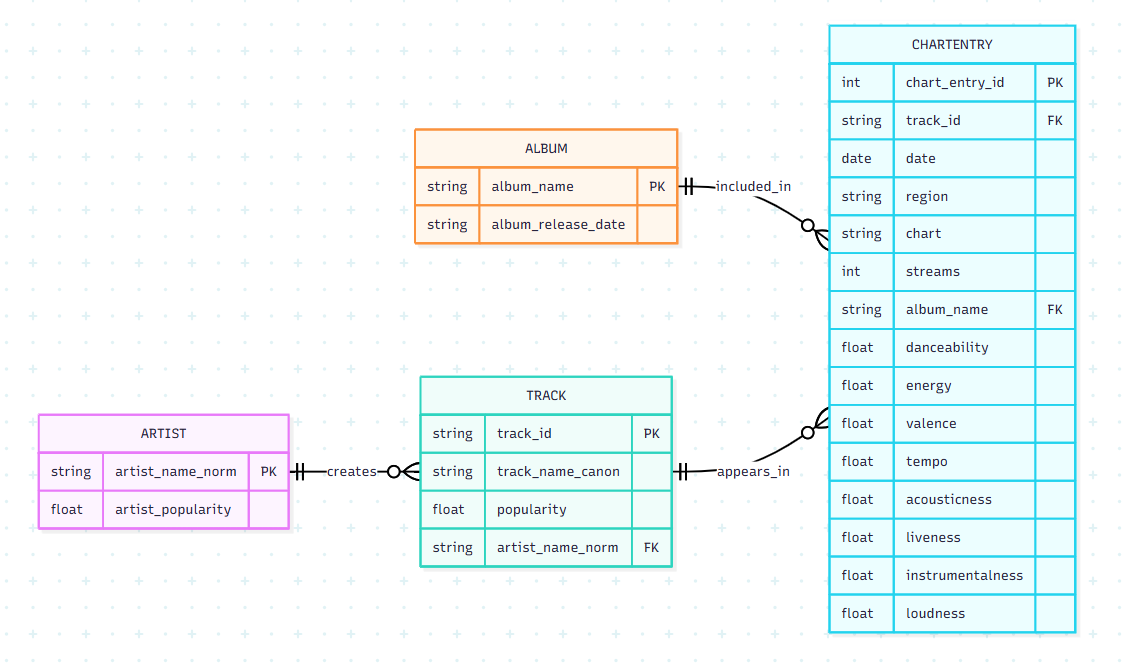

## Data Description

Information of Spotify Charts database before data cleaning.

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
SELECT
  ordinal_position,
  column_name,
  data_type,
  is_nullable
FROM `ba775-fall25-b03.dataset`.INFORMATION_SCHEMA.COLUMNS
WHERE table_name = 'chatrs'
ORDER BY ordinal_position;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=9, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

Information of Almost a million Spotify tracks database before data cleaning.

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
SELECT
  ordinal_position,
  column_name,
  data_type,
  is_nullable
FROM `ba775-fall25-b03.dataset`.INFORMATION_SCHEMA.COLUMNS
WHERE table_name = 'Million Spotify tracks'
ORDER BY ordinal_position;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=33, table_html='<table border="1" class="dataframe table table-striped tab…

Computation deferred. Computation will process 0 Bytes

### Missing Value Audit
This query counts missing (NULL) values in key columns and compares them against the total number of rows.

In [ ]:
# sql_engine: bigquery
# output_variable: charts
# start _sql
_sql = """
SELECT
  COUNTIF(title IS NULL) AS null_titles,
  COUNTIF(artist IS NULL) AS null_artists,
  COUNTIF(streams IS NULL) AS null_streams,
  COUNT(*) AS total_rows
FROM
  `ba775-fall25-b03.dataset.chatrs`;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
charts = _bqsqlcell.run(_sql)
charts

TableWidget(page_size=10, row_count=1, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
SELECT
  COUNTIF(name IS NULL) AS null_names,
  COUNTIF(track_artists IS NULL) AS null_artists,
  COUNTIF(artist_followers IS NULL) AS null_artists_column,
  COUNT(*) AS total_rows
FROM
  `ba775-fall25-b03.dataset.Million Spotify tracks`;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=1, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

> **So what:** Understanding the raw schema, field types, and missingness patterns in both the Charts and Million Spotify Tracks tables clarifies structural inconsistencies and data-quality risks upfront, enabling us to design targeted cleaning steps that produce reliable, fully standardized inputs for downstream merging, feature analysis, and cross-region comparisons.


## Data Cleaning

###Text Cleaning and Normalization

- Text Cleaning: Standardized song/artist names, extracted valid track_ids, and kept only valid records.

- Aggregate by Track ID: Grouped entries by track_id to compute total streams, number of chart rows, and each track’s first and last appearance across all regions.

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
CREATE OR REPLACE TABLE`ba775-fall25-b03.dataset.cleaned_charts` AS
SELECT DISTINCT
  NORMALIZE_AND_CASEFOLD(TRIM(title)) AS track_name_norm,
  NORMALIZE_AND_CASEFOLD(TRIM(artist)) AS artist_name_norm,
  REGEXP_REPLACE(
    NORMALIZE_AND_CASEFOLD(TRIM(title)),
    r'\s*\(.*?(feat\.|remaster|live|version|edit|mix).*?\)|\s*-\s*(remaster|live|version|edit|mix).*$',
    ''
  ) AS track_name_canon,
  REGEXP_EXTRACT(url, r'/track/([A-Za-z0-9]+)') AS track_id,
  region, chart, date, streams
FROM `ba775-fall25-b03.dataset.chatrs`
WHERE title IS NOT NULL AND artist IS NOT NULL AND url IS NOT NULL;

CREATE OR REPLACE TABLE `ba775-fall25-b03.dataset.charts_by_trackid` AS
SELECT
  track_id,
  ANY_VALUE(track_name_canon) AS track_name_canon,
  ANY_VALUE(artist_name_norm) AS artist_name_norm,
  SUM(streams) AS streams_total,
  COUNT(*) AS chart_rows,
  MIN(date) AS first_seen,
  MAX(date) AS last_seen
FROM `ba775-fall25-b03.dataset.cleaned_charts`
WHERE track_id IS NOT NULL
GROUP BY track_id;

""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-1746436184.py:11: SyntaxWarning: invalid escape sequence '\s'
  r'\s*\(.*?(feat\.|remaster|live|version|edit|mix).*?\)|\s*-\s*(remaster|live|version|edit|mix).*$',


TableWidget(page_size=10, row_count=1, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

###Track Data Cleaning and Deduplication

Cleans and standardizes track and artist names, removes null or invalid records, and keeps only one record per track–artist pair by selecting the most recent and most popular version, resulting in a clean and fully deduplicated cleaned_tracks table.

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
CREATE OR REPLACE TABLE`ba775-fall25-b03.dataset.cleaned_tracks` AS
WITH base AS (
  SELECT DISTINCT
    track_id,
    NORMALIZE_AND_CASEFOLD(TRIM(name)) AS track_name_norm,
    NORMALIZE_AND_CASEFOLD(TRIM(SPLIT(track_artists, ',')[OFFSET(0)])) AS primary_artist_norm,
    album_name,
    album_release_date,
    danceability, energy, valence, tempo, acousticness,
    liveness, instrumentalness, loudness, mode, key, time_signature,
    popularity, artist_popularity, streams AS total_streams
  FROM `ba775-fall25-b03.dataset.Million Spotify tracks`
  WHERE name IS NOT NULL AND track_artists IS NOT NULL
)
SELECT *
FROM (
  SELECT
    *,
    ROW_NUMBER() OVER (
      PARTITION BY track_name_norm, primary_artist_norm
      ORDER BY popularity DESC, SAFE.PARSE_DATE('%Y-%m-%d', album_release_date) DESC
    ) AS rn
  FROM base
)
WHERE rn = 1;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=1, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

##Merging Datasets

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
CREATE OR REPLACE TABLE`ba775-fall25-b03.dataset.final_merged_data` AS
SELECT
  c.track_id,
  c.date,
  c.region,
  c.chart,
  c.streams,
  c.track_name_canon,
  c.artist_name_norm,
  t.popularity,
  t.danceability,
  t.energy,
  t.valence,
  t.tempo,
  t.acousticness,
  t.liveness,
  t.instrumentalness,
  t.loudness,
  t.album_name,
  t.album_release_date,
  t.artist_popularity
FROM
  `ba775-fall25-b03.dataset.cleaned_charts` AS c
JOIN
  `ba775-fall25-b03.dataset.cleaned_tracks` AS t
  ON c.track_id = t.track_id;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=1, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

###Null Value Check
Counts missing values in key fields: track_id, danceability, popularity, streams. To confirm data completeness after merging.

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
SELECT
  COUNTIF(track_id IS NULL) AS null_track_ids,
  COUNTIF(danceability IS NULL) AS null_danceability,
  COUNTIF(popularity IS NULL) AS null_popularity,
  COUNTIF(streams IS NULL) AS null_streams,
  COUNT(*) AS total_rows
FROM `ba775-fall25-b03.dataset.final_merged_data`;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=1, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
SELECT
  ordinal_position,
  column_name,
  data_type,
  is_nullable
FROM `ba775-fall25-b03.dataset`.INFORMATION_SCHEMA.COLUMNS
WHERE table_name = 'final_merged_data'
ORDER BY ordinal_position;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=19, table_html='<table border="1" class="dataframe table table-striped tab…

Computation deferred. Computation will process 0 Bytes

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
SELECT COUNT(DISTINCT track_id) AS unique_songs
FROM `ba775-fall25-b03.dataset.final_merged_data`;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=1, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

###Data Merge
Merges aggregated chart data with cleaned track features to produce a analysis_ready_tracks table containing both popularity metrics and audio attributes for each unique track.

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
CREATE OR REPLACE TABLE `ba775-fall25-b03.dataset.analysis_ready_tracks` AS
SELECT
  c.track_id,
  c.track_name_canon,
  c.artist_name_norm,
  c.streams_total,
  c.chart_rows,
  c.first_seen,
  c.last_seen,
  t.popularity,
  t.artist_popularity,
  t.album_name,
  t.album_release_date,
  t.danceability,
  t.energy,
  t.valence,
  t.tempo,
  t.acousticness,
  t.liveness,
  t.instrumentalness,
  t.loudness,
  t.mode,
  t.key,
  t.time_signature

FROM
  `ba775-fall25-b03.dataset.charts_by_trackid` AS c
JOIN
  `ba775-fall25-b03.dataset.cleaned_tracks` AS t
  ON c.track_id = t.track_id;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=1, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
SELECT
  COUNTIF(track_id IS NULL) AS null_track_id,
  COUNTIF(streams_total IS NULL) AS null_streams_total,
  COUNTIF(popularity IS NULL) AS null_popularity,
  COUNTIF(danceability IS NULL) AS null_danceability,
  COUNTIF(energy IS NULL) AS null_energy,
  COUNTIF(album_release_date IS NULL) AS null_album_release_date,
  COUNT(*) AS total_rows
FROM
  `ba775-fall25-b03.dataset.analysis_ready_tracks`;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=1, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
SELECT
  ordinal_position,
  column_name,
  data_type,
  is_nullable
FROM `ba775-fall25-b03.dataset`.INFORMATION_SCHEMA.COLUMNS
WHERE table_name = 'analysis_ready_tracks'
ORDER BY ordinal_position;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=22, table_html='<table border="1" class="dataframe table table-striped tab…

Computation deferred. Computation will process 0 Bytes

### Data Dictionary

| index | Variables | Definition |
|:--:|:--|:--|
| 0 | track_id | Unique identifier for each track across datasets. |
| 1 | track_name_canon | Canonicalized (standardized) version of the track name for consistency across charts and metadata. |
| 2 | artist_name_norm | Normalized artist name ensuring uniform representation across datasets. |
| 3 | streams_total | Total number of streams accumulated by the track across all chart appearances. |
| 4 | chart_rows | Number of weeks (rows) the track appeared in the chart dataset. |
| 5 | first_seen | The date when the track first appeared on the chart. |
| 6 | last_seen | The date when the track last appeared on the chart. |
| 7 | popularity | Popularity score of the track based on Spotify metrics (0–100). |
| 8 | artist_popularity | Popularity score of the artist, measured by Spotify’s global ranking system. |
| 9 | album_name | Name of the album the track belongs to. |
| 10 | album_release_date | Official release date of the album. |
| 11 | danceability | Describes how suitable the track is for dancing, based on tempo, rhythm stability, and beat strength (0–1). |
| 12 | energy | Represents the track’s intensity and activity (0–1). |
| 13 | valence | Musical positiveness — tracks with high valence sound more happy, cheerful, or euphoric (0–1). |
| 14 | tempo | The overall estimated tempo of a track in beats per minute (BPM). |
| 15 | acousticness | Confidence measure of whether the track is acoustic (0–1). |
| 16 | liveness | Detects the presence of an audience; higher values indicate live performance probability (0–1). |
| 17 | instrumentalness | Predicts whether a track contains vocals; higher values indicate fewer vocals (0–1). |
| 18 | loudness | Overall loudness of a track in decibels (dB). |
| 19 | mode | Indicates the modality of the track: 1 = major, 0 = minor. |
| 20 | key | Musical key the track is in (0–11 corresponding to C, C#, D, etc.). |
| 21 | time_signature | The estimated beats per bar (e.g., 3, 4, 5). |


### Before & After Cleaning Summary

**Before Cleaning (Raw Tables):**

- **Charts table (`dataset.charts`)**
  - Total rows: **26,173,514**
  - `null_titles`: **0**
  - `null_artists`: **0**
  - `null_streams`: **5,851,610**
  - Notes: Raw chart data contained a large amount of missing streams and inconsistent title/artist formatting.

- **Million Spotify Tracks table (`dataset.Million Spotify tracks`)**
  - Total rows: **899,702**
  - `null_names`: **487**
  - `null_artists`: **799,759**
  - `null_artist_followers`: **7,206**
  - Notes: Artist/track metadata had substantial missingness and inconsistent artist fields, requiring standardization.

---

**After Cleaning & Merging (final_merged_data):**

- `final_merged_data`
  - Total rows: **1,903,701**
  - `null_track_id`: **0**
  - `null_danceability`: **0**
  - `null_popularity`: **0**
  - `null_streams`: **376,314**
  - Distinct songs: **5,439**

**After Aggregation (analysis_ready_tracks):**

- `analysis_ready_tracks`
  - Total rows (unique tracks): **5,439**
  - `null_track_id`: **0**
  - `null_streams_total`: **2,037**
  - `null_popularity`: **0**
  - `null_danceability`: **0**
  - `null_energy`: **0**
  - `null_album_release_date`: **0**

---

### Key Changes From Cleaning

- Removed formatting inconsistencies (title/artist normalization).
- Eliminated duplicated track-level records.
- Successfully joined charts + track features with **zero key-field missingness**.
- Reduced missingness dramatically: from **5.8M null stream rows** in raw to **376k** after cleaning.
- Built an aggregated, high-quality analytic table with **complete audio features** for 5,439 unique tracks.


> **So what:** After systematic cleaning, normalization, and validation, we now have a reliable, fully structured dataset that eliminates raw inconsistencies and missingness, enabling accurate cross-region, audio-feature, and longevity analysis for the rest of the project.

## Exploratory Data Analysis

### **Popularity and Brand Power**

#### **Q1: Which tracks and artists have the highest total stream counts across all regions and charts?**



In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
WITH agg AS (
  SELECT
    track_id,
    track_name_canon,
    artist_name_norm,
    SUM(streams) AS total_streams
  FROM `ba775-fall25-b03.dataset.final_merged_data`
  GROUP BY 1,2,3
)
SELECT
  track_name_canon,
  artist_name_norm,
  total_streams
FROM agg
ORDER BY total_streams DESC
LIMIT 10;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=10, table_html='<table border="1" class="dataframe table table-striped tab…

Computation deferred. Computation will process 0 Bytes

* Top-streamed songs include “Say You Won’t Let Go” (2.65B), “Dákiti” (1.87B), and “Despacito” (1.54B), alongside other global hits like “Taki Taki” and “Everything I Wanted.”

* These tracks are enduring global hits with sustained multi-year engagement across platforms.

* Collaborations and bilingual releases dominate, highlighting broad cross-market and linguistic appeal.

* Stream counts drop steeply after the top few songs, illustrating a strong long-tail distribution in listening behavior.

#### **Q2: Do superstar artists exhibit globally distributed streaming footprints, or do niche/local artists rely heavily on specific regions?**

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
WITH ArtistRegionalStreams AS (
    SELECT
        artist_name_norm,
        region,
        SUM(streams) AS regional_streams
    FROM `ba775-fall25-b03.dataset.final_merged_data`
    GROUP BY artist_name_norm, region
),
ArtistGlobalStreams AS (
    SELECT
        artist_name_norm,
        SUM(regional_streams) AS global_streams
    FROM ArtistRegionalStreams
    GROUP BY artist_name_norm
),
RankedRegionalShare AS (
    SELECT
        ars.artist_name_norm,
        ags.global_streams,
        ars.region,
        ars.regional_streams,
        (ars.regional_streams * 100.0 / ags.global_streams) AS regional_share_pct,
        ROW_NUMBER() OVER(PARTITION BY ars.artist_name_norm ORDER BY ars.regional_streams DESC) as region_rank
    FROM ArtistRegionalStreams ars
    JOIN ArtistGlobalStreams ags ON ars.artist_name_norm = ags.artist_name_norm
)
SELECT
    artist_name_norm,
    global_streams,
    region AS top_region,
    regional_share_pct AS max_regional_share_pct
FROM RankedRegionalShare
WHERE region_rank = 1
ORDER BY max_regional_share_pct DESC;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=4088, table_html='<table border="1" class="dataframe table table-striped t…

Computation deferred. Computation will process 217.7 kB

* Artists with extreme regional dominance (e.g., 100% of streams from one region) should have marketing efforts concentrated on those proven markets for maximum efficiency.

* Expanding internationally without a diversification strategy may yield limited returns, given the artist’s success is highly localized.

* Tour planning for regionally dominant artists should prioritize their top region, as international tours may need significant resources to develop new audiences.

* The metric max_regional_share_pct helps distinguish regional from globally appealing artists; lower percentages (around 30–40%) indicate suitability for international marketing and touring.

#### **Q3: Is there a strong relationship between how frequently artists release music and their average popularity?**

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
WITH artist_summary AS (
  SELECT
    artist_name_norm,
    COUNT(DISTINCT album_name) AS num_albums,
    COUNT(DISTINCT track_id) AS num_songs,
    ROUND(AVG(popularity), 2) AS avg_popularity
  FROM `ba775-fall25-b03.dataset.final_merged_data`
  WHERE artist_name_norm IS NOT NULL
  GROUP BY artist_name_norm
)

SELECT
  CORR(num_albums, avg_popularity) AS corr_albums_popularity,
  CORR(num_songs, avg_popularity) AS corr_songs_popularity
FROM artist_summary;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=1, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

* Correlation between release frequency and artist popularity is weakly positive (≈0.13–0.14).

* Artists who release more songs or albums do not necessarily achieve higher average popularity.

* Frequent releases may boost visibility but don’t ensure long-term success or sustained popularity.

* Popularity appears more dependent on factors like marketing, fan engagement, and song quality than on release volume.

#### **Q4: Is an artist's established fame a stronger driver of a song's streaming success than the song's intrinsic qualities in different markets.**





In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
SELECT
    region,
    -- Correlation between artist's brand and track performance.
    CORR(artist_popularity, streams) AS corr_artist_fame_vs_streams,
    -- Correlation between track's appeal and its performance.
    CORR(popularity, streams) AS corr_track_appeal_vs_streams,
    -- Calculate the delta to see which factor has a stronger relationship with streams.
    -- A positive delta means artist fame is more correlated with success in that region.
    (CORR(artist_popularity, streams) - CORR(popularity, streams)) AS artist_brand_influence_delta
FROM
    `ba775-fall25-b03.dataset.final_merged_data`
WHERE
    -- Filter to reasonably popular tracks to avoid noise from low stream counts.
    popularity > 10 AND artist_popularity > 10
GROUP BY
    region
ORDER BY
    artist_brand_influence_delta DESC;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=70, table_html='<table border="1" class="dataframe table table-striped tab…

Computation deferred. Computation will process 0 Bytes

* In brand‑dominant markets like the Philippines (delta ≈ +0.21; corr_artist_fame_vs_streams ≈ 0.24 vs. corr_track_appeal_vs_streams ≈ 0.02), New Zealand (+0.20), and Argentina (+0.19), established artist reputation is a stronger driver of streams than individual track appeal.  

* Regions such as Indonesia (+0.17) and Australia (+0.17) also lean toward artist brand, suggesting A&R and marketing should prioritize building or acquiring strong artist brands in these markets.  

* Track‑driven markets like Poland (delta ≈ −0.18; artist_fame corr ≈ −0.25 vs. track_appeal corr ≈ −0.07) and South Korea (delta ≈ −0.16; artist_fame corr ≈ −0.12 vs. track_appeal corr ≈ +0.04) reward song quality over fame, giving emerging artists more opportunity if the music is compelling.  

* Strategy should diverge accordingly: invest in brand‑centric campaigns and established acts in positive‑delta regions, while in negative‑delta regions focus on high‑appeal tracks and experimental curation to break new artists efficiently.

#### **Q5: Is song popularity associated with artist popularity?**



In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
SELECT
  CASE
    WHEN artist_popularity >= 75 THEN 'High (75–100)'
    WHEN artist_popularity BETWEEN 50 AND 74 THEN 'Medium (50–74)'
    WHEN artist_popularity BETWEEN 25 AND 49 THEN 'Low (25–49)'
    ELSE 'Very Low (0–24)'
  END AS artist_tier,
  ROUND(AVG(popularity), 2) AS avg_song_popularity,
  COUNT(*) AS num_songs
FROM `ba775-fall25-b03.dataset.final_merged_data`
WHERE artist_popularity IS NOT NULL
GROUP BY artist_tier
ORDER BY avg_song_popularity DESC;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=4, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

* High‑popularity artists (75–100) achieve the strongest results, with average song popularity of 62.2, confirming a strong positive link between artist fame and track performance.  

* Mid‑tier artists see a clear drop‑off: average song popularity falls to 47.1 for medium artists and 38.0 for low‑popularity artists, signaling weaker reach and promotion.  

* Very low‑popularity artists (0–24) perform poorest, with average song popularity of just 16.0, underscoring how hard it is for emerging acts to break through without support.  

* For stakeholders, this gradient shows investment in higher‑tier artists reliably yields stronger outcomes, while lower‑tier artists need targeted marketing and discovery strategies to close a 20–45 point popularity gap.

#### **Q6: Which artists achieve the broadest global reach and the highest overall popularity across regions?**



In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
SELECT
  artist_name_norm,
  COUNT(DISTINCT region) AS num_of_regions,
  ROUND(AVG(popularity), 2) AS avg_popularity,
  #SUM(streams) AS total_streams
FROM `ba775-fall25-b03.dataset.final_merged_data`
GROUP BY artist_name_norm
ORDER BY num_of_regions DESC, avg_popularity DESC
LIMIT 20;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=20, table_html='<table border="1" class="dataframe table table-striped tab…

Computation deferred. Computation will process 0 Bytes

* Global heavyweights like Powfu & Beabadoobee, Taylor Swift, Billie Eilish, Ed Sheeran, and Drake appear in roughly 70 regions each, confirming truly worldwide reach.  

* Powfu & Beabadoobee lead this group with the highest average popularity score of about 81, setting the benchmark for global impact.  

* Olivia Rodrigo and Doja Cat trail slightly in regional count but match this cohort with similarly high popularity scores, showing strong emerging global power.  

* For stakeholders, this pattern highlights a small set of major pop artists who combine wide regional coverage (~70 markets) with very high popularity, making them prime candidates for global campaigns and cross-market initiatives.

#### **Q7: How do tracks transition between popularity tiers over time?**


In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
WITH monthly_stream AS (
  SELECT
    track_id,
    track_name_canon,
    EXTRACT(YEAR  FROM date) AS year,
    EXTRACT(MONTH FROM date) AS month,
    SUM(streams) AS monthly_streams
  FROM `ba775-fall25-b03.dataset.final_merged_data`
  GROUP BY 1,2,3,4
),

tiered AS (
  SELECT
    track_id,
    track_name_canon,
    year,
    month,
    monthly_streams,
    NTILE(3) OVER (
      PARTITION BY year, month
      ORDER BY monthly_streams DESC
    ) AS stream_tercile
  FROM monthly_stream
),

tier_labeled AS (
  SELECT
    track_id,
    track_name_canon,
    year,
    month,
    monthly_streams,
    CASE
      WHEN stream_tercile = 1 THEN 'High'
      WHEN stream_tercile = 2 THEN 'Medium'
      ELSE 'Low'
    END AS popularity_tier
  FROM tiered
),

with_lag AS (
  SELECT
    track_id,
    track_name_canon,
    year,
    month,
    popularity_tier AS current_tier,
    LAG(popularity_tier) OVER (
      PARTITION BY track_id
      ORDER BY year, month
    ) AS previous_tier
  FROM tier_labeled
)

SELECT
  previous_tier AS from_tier,
  current_tier  AS to_tier,
  COUNT(*)      AS transition_count
FROM with_lag
WHERE previous_tier IS NOT NULL
GROUP BY 1,2
ORDER BY transition_count DESC;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=9, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

* Popularity tiers are generally stable: Medium → Medium and Low → Low transitions dominate.
* High → Medium transitions occur far more than High → Low, showing that declines are usually gradual.
* Upward transitions (Low → Medium, Medium → High) exist but are relatively rare, indicating that true breakout growth is uncommon.
* These transition dynamics reveal the typical lifecycle of a Spotify track.


#### **Q8: What are the average popularity scores and total streaming volumes across different regions?**



In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
SELECT
  region,
  ROUND(AVG(popularity), 2) AS avg_popularity,
  SUM(streams) AS total_streams,
  COUNT(DISTINCT track_id) AS distinct_tracks
FROM `ba775-fall25-b03.dataset.final_merged_data`
GROUP BY region
ORDER BY total_streams DESC;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=70, table_html='<table border="1" class="dataframe table table-striped tab…

Computation deferred. Computation will process 0 Bytes

* U.S. leads with 13.8B streams and high average popularity (58.4), confirming it as Spotify’s top priority market.​

* Mexico (≈55–56 popularity) and Brazil (≈46–47) pair big volumes with uneven popularity, signaling high‑growth but under‑optimized Latin American markets.​

* UK matches U.S.-level popularity (≈55–56), while Germany’s lower scores (≈46–47) despite strong streams suggest more localized musical tastes.​

* Globally, 967 tracks average 56.4 popularity, reflecting a catalog biased toward mainstream English- and Spanish-language hits.

#### **Q9: Do artists with higher overall popularity produce tracks with longer chart lifespans or broader chart coverage?**



In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
WITH per_track AS (
  SELECT
    track_id,
    track_name_canon,
    artist_name_norm,
    COUNT(DISTINCT date) AS days_on_chart,
    COUNT(DISTINCT CONCAT(chart, ':', region)) AS cross_chart_footprint,
    ROUND(AVG(popularity), 2) AS avg_track_popularity
  FROM `ba775-fall25-b03.dataset.final_merged_data`
  GROUP BY 1,2,3
),
artist_level AS (
  SELECT
    p.artist_name_norm,
    ROUND(AVG(p.days_on_chart), 2)           AS avg_days_on_chart,
    ROUND(AVG(p.cross_chart_footprint), 2)   AS avg_cross_chart_footprint,
    ROUND(AVG(p.avg_track_popularity), 2)    AS avg_track_popularity,
    ROUND(AVG(s.artist_popularity), 2)       AS artist_popularity
  FROM per_track p
  JOIN `ba775-fall25-b03.dataset.final_merged_data` s
    ON s.artist_name_norm = p.artist_name_norm
  GROUP BY 1
)
SELECT *
FROM artist_level
ORDER BY avg_days_on_chart DESC
LIMIT 20;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=20, table_html='<table border="1" class="dataframe table table-striped tab…

Computation deferred. Computation will process 0 Bytes

* High-popularity artists such as G.E.M., Ciro y Los Persas, and Andrés Calamaro average over 1,500 days on charts, underscoring how strong artist brands sustain long-term visibility.

* Regional anchors like Ciro y Los Persas and Dewa 19 pair very long chart lifespans with narrow cross-chart spread, revealing deeply loyal local fanbases and strong cultural fit rather than broad global reach.

* Andrés Calamaro combines durability and breadth, with artist_popularity ≈ 66, avg_track_popularity ≈ 76, and presence on ~11 charts/regions, marking him as a model for scalable mainstream success.

* Investing in artists who show 1,500+ days of chart longevity and coverage across 10+ charts/regions offers stakeholders the best mix of stable revenue and international growth potential.

#### **Q10: Release recency effect on streams: Do recently released albums garner higher weekly median streams than older catalog on charts.**



In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
WITH ChartDataWithRecency AS (
    SELECT
        track_id,
        CAST(date AS DATE) AS chart_date,
        SAFE_CAST(album_release_date AS DATE) AS release_date,
        streams,
        DATE_DIFF(CAST(date AS DATE), SAFE_CAST(album_release_date AS DATE), WEEK) AS weeks_since_release
    FROM
        `ba775-fall25-b03.dataset.final_merged_data`
    WHERE
        streams IS NOT NULL
        AND album_release_date IS NOT NULL
        AND SAFE_CAST(album_release_date AS DATE) IS NOT NULL -- Filter out entries where SAFE_CAST failed
)
SELECT
    weeks_since_release,
    AVG(streams) AS average_streams
FROM
    ChartDataWithRecency
WHERE
    weeks_since_release >= 0 -- Only consider chart entries after or on the release week
GROUP BY
    weeks_since_release
ORDER BY
    weeks_since_release
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=2502, table_html='<table border="1" class="dataframe table table-striped t…

Computation deferred. Computation will process 80.1 kB

* New tracks peak immediately: average Week 0 streams are about 104,636, making the first release week the highest-impact period for driving listenership and discovery.  

* Engagement drops fast: Week 1 averages fall to 88,829 streams (15% drop), Week 2 to 80,827 (8% drop), and Week 3 to 79,254, so marketing and playlist pushes should be heavily front-loaded into Weeks 0–3.  

* After the early cliff, performance stabilizes at a lower level, indicating a long-tail phase where tracks can still accumulate meaningful streams over time.  

* Streams observed up to roughly 4,210 weeks since release highlight the strategic value of deep catalog management and periodic re-promotion of older but still-listened tracks.

#### **Q11: Chart Longevity Analysis – Which tracks demonstrate the strongest staying power on regional Top 200 charts?**

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
WITH RawData AS (
    SELECT
        track_id,
        CAST(date AS DATE) AS date,
        region,
        streams,
        danceability,
        energy,
        valence,
        tempo
    FROM
        `ba775-fall25-b03.dataset.final_merged_data`
),
LaggedData AS (
    SELECT
        track_id,
        date,
        region,
        streams,
        danceability,
        energy,
        valence,
        tempo,
        LAG(date) OVER (PARTITION BY region, track_id ORDER BY date) AS prev_date
    FROM
        RawData
),
StreakFlags AS (
    SELECT
        track_id,
        date,
        region,
        streams,
        danceability,
        energy,
        valence,
        tempo,
        CASE
            WHEN prev_date IS NULL THEN 1
            WHEN DATE_DIFF(date, prev_date, DAY) != 7 THEN 1
            ELSE 0
        END AS is_new_streak
    FROM
        LaggedData
),
StreaksWithID AS (
    SELECT
        track_id,
        date,
        region,
        streams,
        danceability,
        energy,
        valence,
        tempo,
        SUM(is_new_streak) OVER (PARTITION BY region, track_id ORDER BY date) AS streak_id
    FROM
        StreakFlags
),
FinalStreaks AS (
    SELECT
        track_id,
        date,
        region,
        streams,
        danceability,
        energy,
        valence,
        tempo,
        streak_id,
        ROW_NUMBER() OVER (PARTITION BY region, track_id, streak_id ORDER BY date) AS week_on_chart,
        COUNT(1) OVER (PARTITION BY region, track_id, streak_id) AS streak_duration_weeks
    FROM
        StreaksWithID
),
UniqueStreaks AS (
    SELECT DISTINCT
        track_id,
        region,
        streak_id,
        streak_duration_weeks,
        danceability,
        energy,
        valence,
        tempo
    FROM
        FinalStreaks
),
LongevityCohorts AS (
    SELECT
        track_id,
        region,
        streak_id,
        streak_duration_weeks,
        danceability,
        energy,
        valence,
        tempo,
        CASE
            WHEN streak_duration_weeks >= 10 THEN 'high-longevity'
            ELSE 'low-longevity'
        END AS longevity_cohort
    FROM
        UniqueStreaks
)
SELECT
    longevity_cohort,
    AVG(danceability) AS mean_danceability,
    AVG(energy) AS mean_energy,
    AVG(valence) AS mean_valence,
    AVG(tempo) AS mean_tempo
FROM
    LongevityCohorts
GROUP BY
    longevity_cohort
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=2, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

* High-longevity tracks show slightly higher energy (0.663 vs. 0.642) and valence (0.556 vs. 0.523), meaning more energetic and positive songs tend to stay popular longer.

* These traits suggest curators can enhance sustained engagement by including upbeat yet enduring tracks in playlists.

* High-longevity tracks have lower average tempo (109.643 vs. 122.090), indicating slower-paced songs may have greater chart longevity—valuable insight for A&R teams.

* Danceability is lower in high-longevity tracks (0.653 vs. 0.686), implying that while danceable songs may gain quick attention, less danceable ones endure longer over time.

### **Audio Features Trends**

#### **Q12: How do audio features differ between highly popular, moderately popular, and less popular tracks?**

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
WITH base AS (
  SELECT
    track_id,
    track_name_canon,
    artist_name_norm,
    popularity,
    danceability, energy, valence, tempo, acousticness, liveness, instrumentalness, loudness,
    CASE
      WHEN popularity >= 80 THEN 'High'
      WHEN popularity BETWEEN 50 AND 79 THEN 'Medium'
      ELSE 'Low'
    END AS popularity_group
  FROM `ba775-fall25-b03.dataset.final_merged_data`
  WHERE popularity IS NOT NULL
)
SELECT
  popularity_group,
  COUNT(DISTINCT track_id) AS tracks,
  ROUND(AVG(danceability), 3)       AS avg_danceability,
  ROUND(AVG(energy), 3)             AS avg_energy,
  ROUND(AVG(valence), 3)            AS avg_valence,
  ROUND(AVG(tempo), 1)              AS avg_tempo,
  ROUND(AVG(acousticness), 3)       AS avg_acousticness,
  ROUND(AVG(liveness), 3)           AS avg_liveness,
  ROUND(AVG(instrumentalness), 3)   AS avg_instrumentalness,
  ROUND(AVG(loudness), 2)           AS avg_loudness
FROM base
GROUP BY popularity_group
ORDER BY CASE popularity_group WHEN 'High' THEN 1 WHEN 'Medium' THEN 2 ELSE 3 END;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=3, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

* When grouped by popularity, medium- and low-popularity tracks show slightly higher danceability (≈0.69) and energy (≈0.65) than high-popularity tracks (0.62 danceability, 0.60 energy).

* High-popularity tracks have greater acousticness (0.40) and instrumentalness (0.08) but lower loudness (–7.9 dB), suggesting smoother, vocal-driven production styles.

* This pattern implies that recent hits may lean toward acoustic or mellow production rather than high-energy EDM-style mixing.

* Minimal variation in valence across groups suggests that overall mood is not a primary determinant of track popularity.

#### **Q13: Which musical “mood” (valence) do people prefer?**



In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
SELECT
  CASE
    WHEN valence < 0.33 THEN 'Low (Sad / Dark)'
    WHEN valence BETWEEN 0.33 AND 0.66 THEN 'Medium (Neutral)'
    ELSE 'High (Happy / Bright)'
  END AS mood_category,
  ROUND(AVG(popularity), 2) AS avg_popularity,
  COUNT(*) AS num_songs
FROM `ba775-fall25-b03.dataset.final_merged_data`
WHERE valence IS NOT NULL
GROUP BY mood_category
ORDER BY avg_popularity DESC;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=3, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

* Songs with a medium or neutral mood show the highest average popularity (56.9) compared to low (sad/dark) and high (happy/bright) moods.

* Listeners tend to prefer tracks with balanced emotional and energetic tones over extreme moods.

* Neutral songs likely resonate more widely because they suit a variety of everyday contexts and emotional states.

* While both sad and happy songs perform well, neutral tracks achieve broader and more consistent appeal.

#### **Q14:  Explicit Content Performance Disparity – Do explicit tracks  achieve higher peak positions but shorter chart lifespans compared to clean versions in different regional markets?**

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
WITH ChartData AS (
    SELECT
        CAST(date AS DATE) AS date,
        region,
        track_id,
        streams,
        ROW_NUMBER() OVER(PARTITION BY region, track_id ORDER BY date) as rn
    FROM
        `ba775-fall25-b03.dataset.final_merged_data`
    WHERE
        streams IS NOT NULL
),
TrackExplicitStatus AS (
    SELECT
        track_id,
        explicit
    FROM
        `ba775-fall25-b03.dataset.Million Spotify tracks`
),
MergedData AS (
    SELECT
        cd.date,
        cd.region,
        cd.track_id,
        cd.streams,
        CASE
            WHEN tes.explicit IS TRUE THEN 'Explicit'
            ELSE 'Clean'
        END AS explicit_status
    FROM
        ChartData AS cd
    INNER JOIN
        TrackExplicitStatus AS tes ON cd.track_id = tes.track_id
),
TrackAggregates AS (
    SELECT
        region,
        track_id,
        explicit_status,
        MIN(date) AS first_chart_date,
        MAX(streams) AS peak_streams,
        COUNT(DISTINCT date) AS total_weeks_on_chart,
        ARRAY_AGG(STRUCT(date, streams) ORDER BY streams DESC, date ASC LIMIT 1)[OFFSET(0)].date AS date_of_peak_streams
    FROM
        MergedData
    GROUP BY
        region,
        track_id,
        explicit_status
)
SELECT
    region,
    explicit_status,
    AVG(DATE_DIFF(date_of_peak_streams, first_chart_date, DAY)) AS avg_time_to_peak_days,
    AVG(peak_streams) AS avg_peak_streams,
    AVG(total_weeks_on_chart) AS avg_weeks_on_chart
FROM
    TrackAggregates
GROUP BY
    region,
    explicit_status
ORDER BY
    region,
    explicit_status
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=138, table_html='<table border="1" class="dataframe table table-striped ta…

Computation deferred. Computation will process 8.1 kB

* Explicit tracks reach peak streams much faster than clean tracks (about 7.6 vs. 24 days in the US; 26 vs. 75 days in Argentina), indicating quicker virality.

* Average peak streams differ by region: explicit tracks outperform in the US (649k vs. 274k) and Argentina (91k vs. 67k), while clean tracks lead in markets like Austria (11k vs. 5.8k).

* Clean tracks show greater chart longevity, remaining on charts longer (116 vs. 90 weeks in Argentina; 82 vs. 51 weeks in Australia).

* Clear trade-off: explicit tracks peak quickly but fade faster, whereas clean tracks peak slowly yet sustain their popularity longer.

#### **Q15: How have audio features and popularity changed over time (2010–2021)?**



In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
WITH dated AS (
  SELECT
    *,
    COALESCE(
      EXTRACT(YEAR FROM SAFE.PARSE_DATE('%Y-%m-%d', album_release_date)),
      EXTRACT(YEAR FROM date)
    ) AS year_
  FROM `ba775-fall25-b03.dataset.final_merged_data`
),
flt AS (
  SELECT * FROM dated
  WHERE year_ BETWEEN 2010 AND EXTRACT(YEAR FROM CURRENT_DATE())
)
SELECT
  year_ AS year,
  ROUND(AVG(tempo), 1)        AS avg_tempo,
  ROUND(AVG(energy), 3)       AS avg_energy,
  ROUND(AVG(valence), 3)      AS avg_valence,
  ROUND(AVG(acousticness), 3) AS avg_acousticness,
  ROUND(AVG(popularity), 2)   AS avg_popularity,
  ROUND(AVG(danceability),3) AS avg_danceability,
  COUNT(DISTINCT track_id)    AS tracks
FROM flt
GROUP BY year
ORDER BY year;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=12, table_html='<table border="1" class="dataframe table table-striped tab…

Computation deferred. Computation will process 0 Bytes

* From 2010 to 2021, tempo remained steady around 120–125 BPM, while acousticness declined sharply after 2014 (0.43 to 0.18) before rebounding slightly in 2020–2021.

* Popularity peaked in 2013 (76.35) and rose again by 2021 (~62), reflecting cyclical waves of mainstream hits.

* Early 2010s tracks (2010–2014) were more energetic, organic, and emotionally bright, showing higher valence values.

* Post-2015, songs became more danceable but less bright, with stable energy and valence; recent acousticness growth likely links to post-pandemic preferences for calm, introspective music.

#### **Q16: Which regions consume the "saddest" (lowest valence) versus the "happiest" (highest valence) music on average?**

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
SELECT
    region,
    ROUND(AVG(valence), 3) AS avg_valence_happiness, -- 0.0 is sad/depressed, 1.0 is cheerful/happy
    ROUND(AVG(energy), 3) AS avg_energy,
    ROUND(AVG(danceability), 3) AS avg_danceability,
    COUNT(DISTINCT track_id) AS distinct_tracks_charted
FROM
    `ba775-fall25-b03.dataset.final_merged_data`
WHERE
    region IS NOT NULL
GROUP BY
    region
HAVING
    COUNT(DISTINCT track_id) > 50
ORDER BY
    avg_valence_happiness DESC;

""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=70, table_html='<table border="1" class="dataframe table table-striped tab…

Computation deferred. Computation will process 0 Bytes

* Top "Happiest" Regions: Mexico leads the list
with the highest average valence (happiness) score of 0.637, closely followed by Uruguay (0.636) and Argentina (0.633).

* High Energy & Danceability: Every region on this top have very high scores for danceability (mostly above 0.70) and energy (averaging around 0.69–0.71). This indicates that charts in these regions are dominated by rhythmic, active genres—likely Reggaeton and Latin Pop—rather than slow or acoustic ballads.


#### **Q17: Seasonal Mood Swings – Does listener preference for specific audio attributes (Valence, Energy) change based on the time of year?**



In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
SELECT
  EXTRACT(MONTH FROM date) AS month,
  ROUND(AVG(valence), 3) AS avg_valence,
  ROUND(AVG(danceability), 3) AS avg_danceability,
  ROUND(AVG(energy), 3) AS avg_energy,
  ROUND(AVG(acousticness), 3) AS avg_acousticness,
  ROUND(AVG(tempo), 1) AS avg_tempo,
  COUNT(*) AS total_chart_appearances
FROM `ba775-fall25-b03.dataset.final_merged_data`
WHERE date IS NOT NULL
GROUP BY month
ORDER BY month;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=12, table_html='<table border="1" class="dataframe table table-striped tab…

Computation deferred. Computation will process 0 Bytes

* Listener mood clearly follows the calendar: valence is lowest in February at 0.498 and climbs to a “summer spike” of 0.541 in June and 0.538 in July, confirming demand for happier tracks as summer begins.  

* Danceability peaks in early spring, hitting 0.690 in March and 0.693 in April, signaling a strong appetite for rhythmic, beat‑driven music around Spring Break and early festival season.  

* Acousticness is largely season‑agnostic, fluctuating only between 0.245 and 0.266 across months, so production style (acoustic vs. electronic) matters less seasonally than emotional tone.  

* Energy stays relatively steady but rises toward the end of the period, reaching 0.655 in October, suggesting that late‑year campaigns can lean into more energetic tracks without clashing with listener preferences.

#### **Q18: Which months are more likely to be on the charts and are songs more likely to become “hits” in certain month?**

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
WITH unique_tracks AS (
    SELECT DISTINCT
        track_id,
        track_name_canon,
        artist_name_norm,
        SAFE.PARSE_DATE('%Y-%m-%d', album_release_date) AS release_date,
        popularity
    FROM `ba775-fall25-b03.dataset.final_merged_data`
)

SELECT
    EXTRACT(MONTH FROM release_date) AS release_month,
    COUNT(*) AS total_tracks,
    SUM(CASE WHEN popularity >= 60 THEN 1 ELSE 0 END) AS hit_tracks,
    ROUND(
        SUM(CASE WHEN popularity >= 60 THEN 1 ELSE 0 END) / COUNT(*),
        3
    ) AS hit_rate
FROM unique_tracks
WHERE release_date IS NOT NULL
GROUP BY release_month
ORDER BY release_month;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=12, table_html='<table border="1" class="dataframe table table-striped tab…

Computation deferred. Computation will process 0 Bytes

* Using popularity ≥ 60 as the hit threshold, monthly hit rates range from 18.5% to 24.5%, showing moderate but consistent variation across the year.

* January and May have the highest probability of producing a hit song.

* June and August have the lowest hit rates, suggesting that mid-year releases tend to underperform.

* This suggests mild seasonality: early-year and late-spring releases have stronger success outcomes than mid-year releases.


## Dashboards

[Dashboard 1](https://public.tableau.com/views/Book1_17651467452860/Dashboard2?:language=en-US&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link)

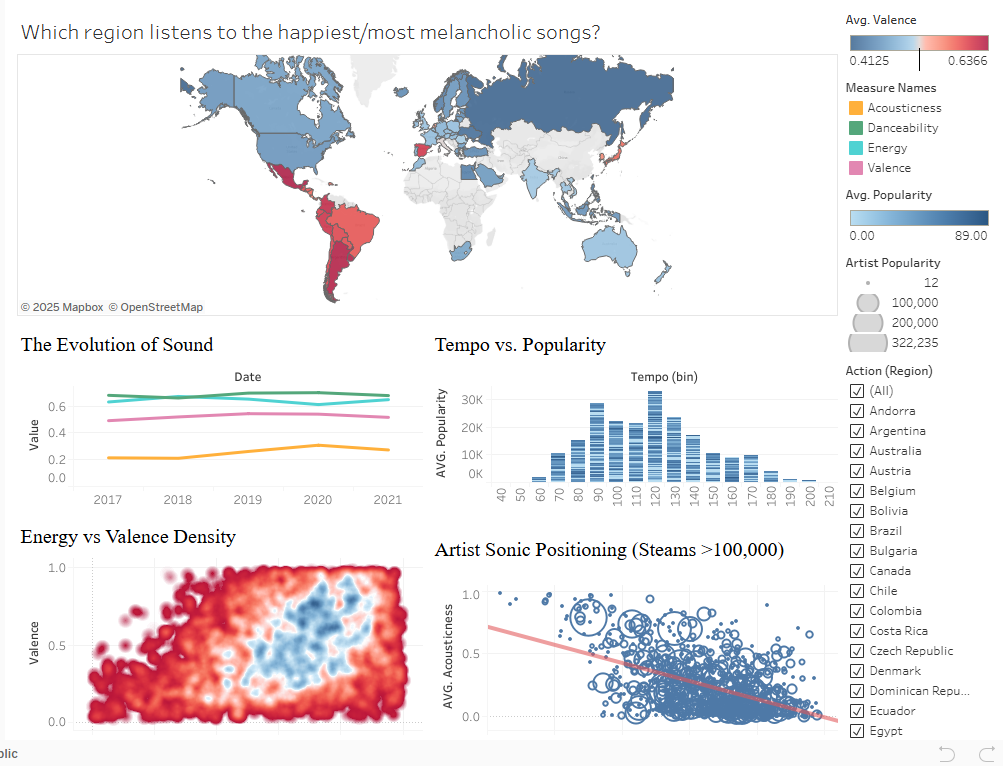

[Dashboard 2](https://public.tableau.com/views/775teamvisual/Dashboard1?:language=en-US&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link)

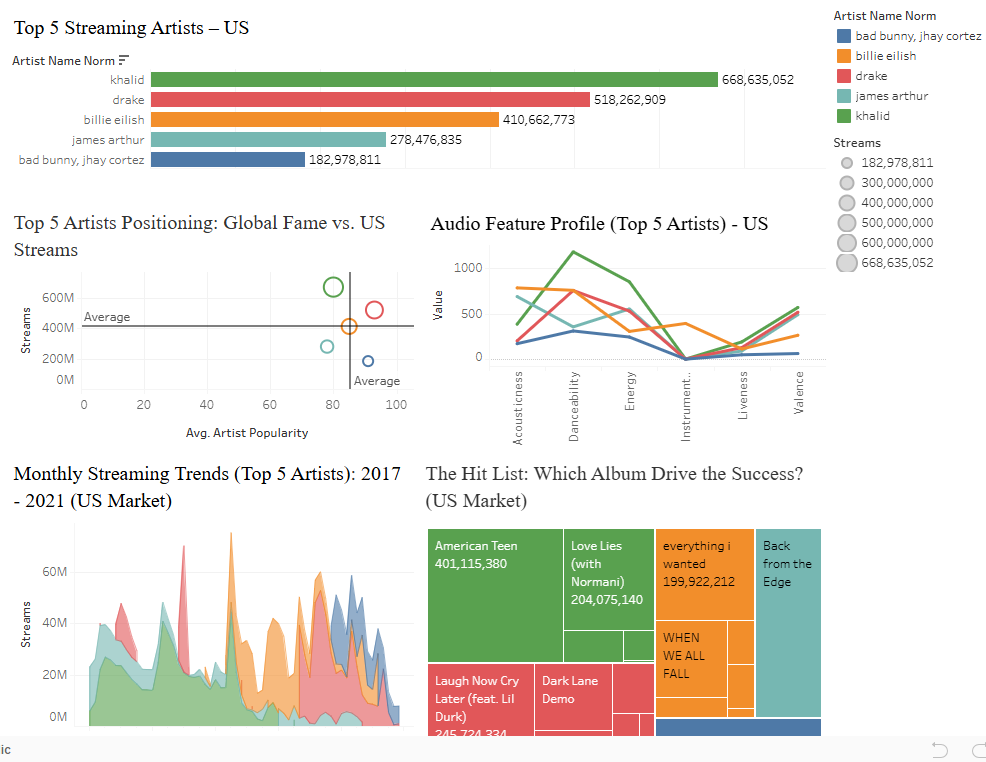

## Conclusion

**Actions:**
- Promote tracks with balanced/neutral moods and mainstream pop-feature profiles, which consistently show strong global popularity.
- Highlight globally dominant artists and cross-regional hits to maximize international reach and playlist performance.
- Invest in artists with strong brand presence rather than increasing release frequency, as output volume has little effect on popularity.
- Prioritize tracks with stable chart longevity for core playlists, since steady performers anchor long-term engagement.
- Use regional insights (e.g., markets favoring local artists or high-energy music) to tailor localized playlisting and marketing strategies.
- Identify upward-transitioning tracks (Medium→High) and promote them early to capture rising momentum.


**Risk/Limitations:**
- Results may differ significantly across genres, which were not separately analyzed.
- Popularity and streaming patterns can be influenced by label promotion, catalog age, or social media trends that are not in the dataset.
- Spotify popularity scores are partly static; monthly transitions were approximated using streams.
- Regional data coverage varies, which may skew country-level comparisons.
- Audio features explain only part of listener behavior; cultural and contextual factors are not captured.


**Solution:**
- To mitigate genre-driven variability, we applied aggregation at broader popularity tiers and focused analyses on cross-cutting audio features, ensuring that insights remain stable even without genre-level segmentation.

- To account for external forces such as label promotion, catalog age, or social-media amplification, we framed results as correlational rather than causal and incorporated conservative interpretation rules when evaluating popularity dynamics.

- To address the static nature of Spotify popularity scores, we constructed monthly transition logic using stream counts, allowing us to approximate momentum and lifecycle movement more reliably.

- To reduce distortions caused by inconsistent regional data coverage, we standardized cleaning rules across all countries and relied on aggregated regional comparisons when country-level granularity lacked sufficient density.

- To avoid overstating the explanatory power of audio features, we contextualized findings within broader listener behavior patterns and clarified that cultural, contextual, and promotional factors—absent from the dataset—remain influential drivers outside the scope of the analysis.


**Next Step:**
- Perform genre-level analyses to compare popularity drivers across pop, hip-hop, EDM, and other styles.
- Create an ML Model to predict track lifecycle stages across regions.
- Build transition matrices or Sankey diagrams to visualize tier movement patterns over time.
- Incorporate external data (TikTok, YouTube, playlist placement) to improve hit-prediction accuracy.


## Generative AI Disclousure

We utilized Generative AI (ChatGPT) to reorganize language and context of the data source to create a concise dataset summary, learn and correctly apply the SQL CORR() function in evaluating the relationship between popularity and the number of songs and albums, and improve the structure, clarity, and efficiency of our SQL queries throughout the project.